# Table of Contents:
   [Business Prop:](#Business_Prop:)
   
   [Organizing the Data](#Organizing_the_Data)
   
   [Import Statements](#Import_Statements)
   
   [EDA](#EDA)
   
   [Data Cleaning](#Data_cleaning)
   
   [Word Cloud](#wordclouds)
   
   [Data for Modeling](#Data_for_Modeling)
   
   [TF-IDF](#TF-IDF)
   
   [Modeling](#Modeling)
   
   [FSM](#FSM)
   
   [Gridsearch](#Gridsearch)
   
   [Instantiate Pipelines](#Instantiate_Pipelines)
   
   [Tuned Models](#Tuned_Models)
   
   [Vectorizer Tuning](#Vectorizer_Tuning)
   
   [Vectorizer Tuning: by Model](#Vectorizer_Tuning:_by_Model)
   
   [Final Yelp Model](#Final_Yelp_Model)
   
   [Key Features](#Key_Features)
   
   [Pickle Model](#Pickle_Model)
   
   [Grubhub Review Data](#Grubhub_Review_Data)
   
   [Grubhub EDA](#Grubhub_EDA)
   
   [Grubhub Modeling](#Grubhub_Modeling)
   
   [Next Steps](#Next_Steps)

# Business Prop:
Most businesses in the world today have some kind of online presence with their customers. Many allow customers to leave a star rating and review of the product or service thay recieved. Most of their customers use these services as well with "91% of 18-34 year olds trust online reviews as much as personal recommendations, and 93% of consumers say that online reviews influenced their purchase decisions." [qualtrics](https://www.qualtrics.com/blog/online-review-stats/) This makes these reviews extremely valuable as far as data is concerned, it allows the producer to monitor what is and isn't working so they can adjust accordingly and it allows the customer to have a voice in a product or service they might like to keep using. However, due to the variability of human nature, the star rating system that often accompanies reviews is often not uniformly used. Such as reviews gettung an overly negative rating for mediocre service or an overly good rating for adequate service. The most ambiguous of these is the three star rating. Out of 1211 participants in on study said they feel a three star rating in a positive light. [alittlehazebookblog](https://alittlehazebookblog.wordpress.com/2020/09/02/the-uncertainty-of-the-three-star-review-a-thought-piece/) While another stated that a "3.3 is the minimum star rating of a business consumers would engage with." [qualtircs](https://www.qualtrics.com/blog/online-review-stats/) Which makes it seem like a much more negative rating. The aim of this project is to help companies utulize the data they already have, these reviews and rating systems, to disambiguate those three star reviews into data they can better use. To do this I will build a text based NLP binary classification model. This model will take in three star reviews and designate them as either positive or negative based on the actual text of the review. 



In [4]:
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
nltk.download('punkt')
nltk.download('tagsets')
nltk.help.upenn_tagset()
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import random
import pickle #install
import pandas as pd
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from statistics import mode #install
import json
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from xgboost import XGBClassifier
from src.yelp import get_wordnet_pos, data_cleaner, num_to_cat, conf_matrix_plotter, retagger, gb_cleaner, wordcloud_maker

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edwardsrk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\edwardsrk\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edwardsrk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\edwardsrk\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# Organizing the Data

The code below details how I read in and split 10,000 reivews for some inital EDA. The Yelp open source academic dataset contains about 8 million reviews. These reviews can be broken down into their user designated star ratings as follows:
3586460 five star reviews, 1673404 four star reviews, 842289 three star reviews, 635072 two star reviews and 1283897 one star reviews. To create a dataet that would fall into two classes I combined one and two stars reviews for my negative class and I combined four adn five star reivews for my positive class. As you can see from the numbers above this dataset skewed by having more positve reviews than negative at a 5:2 ratio. To reflect that distribution in my EDA datasets and to make this project mroe mangeable, I scaled down my data to 7500 positive reviews and 3000 negative reivews.

In [5]:
with open ('./data/pickles/71k_sample.p', "rb") as readfile: 
    X, y = pickle.load(readfile)

In [6]:
df_strat = X.copy()

In [7]:
df_strat['stars'] = y

In [8]:
df_strat['tag'] = df_strat.stars.apply(num_to_cat)

In [9]:
df_strat.head()

,text,stars,tag
1428078,"TYLER IS AMAZING!!!!\n\nWonderful, wonderful, ...",5,pos
3626079,"First off, great beer selection. I always sit...",4,pos
1695262,The space looks very different in person than ...,4,pos
6584691,The ambiance is very dated and cost is very pr...,3,neg
6429535,"All you can eat for $25 plus tax, can't go wro...",4,pos


In [10]:
y_one_star = df_strat[df_strat['stars'] == 1]
y_two_star = df_strat[df_strat['stars'] == 2]
y_three_star = df_strat[df_strat['stars'] == 3]
y_four_star = df_strat[df_strat['stars'] == 4]
y_five_star = df_strat[df_strat['stars'] == 5]

In [11]:
len(y_five_star), len(y_four_star), len(y_three_star), len(y_two_star), len(y_one_star)

(35865, 16734, 8423, 6351, 12839)

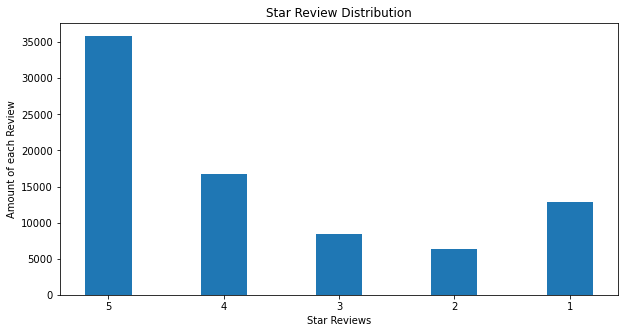

In [12]:
y_lens = {'5' :len(y_five_star), '4':len(y_four_star), '3' :len(y_three_star), '2' :len(y_two_star), '1' : len(y_one_star)}

y_x = list(y_lens.keys())
y_y = list(y_lens.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(y_x,y_y, width = 0.4)

plt.xlabel("Star Reviews")
plt.ylabel("Amount of each Review")
plt.title("Star Review Distribution")
plt.show()

In [13]:
df_strat = df_strat[df_strat['stars'] != 3]

In [14]:
df_strat.head()

,text,stars,tag
1428078,"TYLER IS AMAZING!!!!\n\nWonderful, wonderful, ...",5,pos
3626079,"First off, great beer selection. I always sit...",4,pos
1695262,The space looks very different in person than ...,4,pos
6429535,"All you can eat for $25 plus tax, can't go wro...",4,pos
1687838,Service was really slow. Our waitress kept tal...,2,neg


In [15]:
pos_dfs = [y_five_star, y_four_star]
y_pos = pd.concat(pos_dfs)
neg_dfs = [y_one_star, y_two_star]
y_neg = pd.concat(neg_dfs)

In [16]:
y_neg

,text,stars,tag
7733398,First time trying to eat here and will be the ...,1,neg
3697983,There is a lady who works here named Marie Ann...,1,neg
4880533,I called Muddy Waters 3 weeks ago and made res...,1,neg
5799494,Was in shocked the way i was spoken to wen i c...,1,neg
6786848,I wish I could give this place zero stars. Th...,1,neg
...,...,...,...
2351912,"Not All That\n\nWe had seen the Triple D show,...",2,neg
7287509,4 boba teas + + 2 spicy dumplings + 2 rice dis...,2,neg
383129,After reading other Yelpers reviews I took my ...,2,neg
499739,I was really excited to have a coffee shop be ...,2,neg


In [17]:
y_neg_list = y_neg.text.tolist()
y_pos_list = y_pos.text.tolist()

In [18]:
documents = []

for i in y_neg_list:
    documents.append(i)
    
for j in y_pos_list:
    documents.append(j)


In [19]:
len(documents), len(y_neg_list), len(y_pos_list)

(71789, 19190, 52599)

In [20]:
y_neg_toke = []
for i in y_neg_list:
    y_neg_toke.append(word_tokenize(i))
    
y_pos_toke = []
for j in y_pos_list:
    y_pos_toke.append(word_tokenize(j))

In [21]:
#doc_toke = []
#for i in documents:
#    doc_toke.append(word_tokenize)

In [22]:
y_neg_toke_flat = [word for doc in y_neg_toke for word in doc]
y_pos_toke_flat = [word for doc in y_pos_toke for word in doc]

In [23]:
all_words_raw = []

In [24]:

for w in y_pos_toke_flat :
    all_words_raw.append(w)
print(len(all_words_raw))
    
for w in y_neg_toke_flat:
    all_words_raw.append(w)
print(len(all_words_raw))

#append tokenized data to all_words_raw

5716841
8814849


# EDA

In [25]:
print(len(all_words_raw))
#check length

8814849


In [26]:
tokens = all_words_raw
types = set(tokens)
len(types), len(tokens)

#create token and type vars

(112269, 8814849)

In [28]:
fdist1 = nltk.FreqDist(tokens)
fdist1
#create frequency distribution, checks all tokens and how often they occur in the vocab
#prints out top 10 most used, these are usally stopwrods as the data has not been cleaned

FreqDist({'.': 454598, 'the': 310417, 'and': 267598, ',': 246632, 'I': 228246, 'to': 190204, 'a': 184421, 'was': 138450, '!': 110857, 'of': 106134, ...})

You can see from the frequencey distribution below that most of the most frequent words are stop words that will need to be stripped away later.

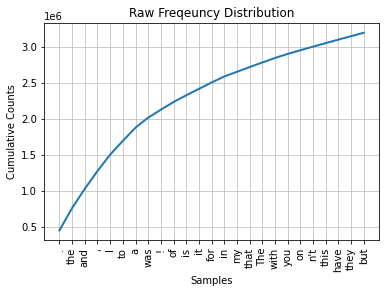

In [31]:
fdist1.plot(25, title = 'Raw Freqeuncy Distribution', cumulative = True);

In [32]:
fdist1.hapaxes()[:10]
#first ten unique words

['TYLER',
 'Appt',
 'Eggnog',
 'Abuelos',
 'Babbs',
 'foMy',
 'regrowing',
 'jeered',
 'DESTINY',
 'Daddys']

In [33]:
fdist1['the'], fdist1.freq('the')
#shows count of the word and frequency with which it appears

(310417, 0.0352152373795626)

The following cells show a few NLP techniques that show why cleaning your data is important and that as you clean the amount of data you have goes down but that what is left is more lexically and semantically rich data. This more content heavy data is what the models will use to really do their predictions. Much of the other stuff that gets filtered out is considered to be noise.

In [34]:
words_lower = [w.lower() for w in all_words_raw]
#list comprehension for making all words lower case

In [35]:
len(words_lower)

8814849

In [36]:
words_npunc = [w for w in words_lower if w.isalpha()]
len(words_npunc)
# list comp for all words that are alpha numeric, no punctuation

7572523

In [37]:
fdist2 = nltk.FreqDist(words_npunc)
#check freq dist again

In [38]:
fdist2
#punctuation gone

FreqDist({'the': 375431, 'and': 273714, 'i': 234863, 'to': 191791, 'a': 189294, 'was': 139634, 'it': 110264, 'of': 106839, 'is': 94011, 'for': 91730, ...})

In [39]:
#from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#get a list of stop words from nltk

In the last sample cleaning technique below, stripping the stop words you can see we have pared downt he data from 1263624 words to 538646. That is almost cutting it in half. Doing htis allows the model to run faster while making more accurate predictions on real content words that distinguish the classes.

In [40]:
all_words_nstop = [w for w in words_npunc if not w in stop_words]
len(all_words_nstop)
#list comp to remove all stop words

3765388

In [41]:
fdist3 = nltk.FreqDist(all_words_nstop)
fdist3
#thrid freqdist to check stopwords are gone

FreqDist({'food': 34087, 'place': 33568, 'great': 31415, 'good': 31374, 'service': 25474, 'time': 24656, 'would': 23473, 'like': 23149, 'get': 23052, 'one': 22561, ...})

These two histograms show the distribution of words among each document within its class. As you can see, the positive reviews are much more vebose than the negative ones.

In [42]:
neg_doc_lengths = []
pos_doc_lengths = []
for doc in y_neg_list:
    neg_doc_lengths.append(len(doc))

for doc in y_pos_list:
    pos_doc_lengths.append(len(doc))

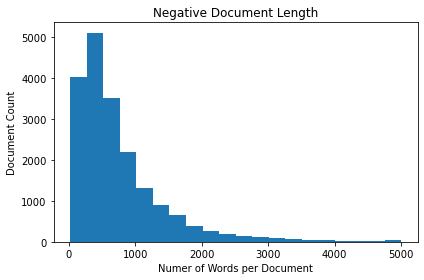

In [43]:
n_bins = 20
fig, axs = plt.subplots(1, sharey=True, tight_layout=True)
axs.hist(neg_doc_lengths, bins=n_bins)
axs.set_title("Negative Document Length");
axs.set_xlabel('Numer of Words per Document');
axs.set_ylabel("Document Count");


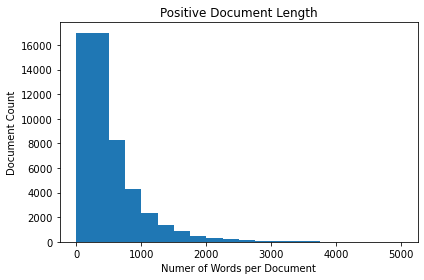

In [44]:
fig, axs = plt.subplots(1, sharey=True, tight_layout=True)
axs.hist(pos_doc_lengths, bins=n_bins)
axs.set_title("Positive Document Length");
axs.set_xlabel('Numer of Words per Document');
axs.set_ylabel("Document Count");

# Data Cleaning

Data cleaning is required to make models run faster and have more accurate predicitons. In this notebook the cleaning steps I will use are: Part of speech tagging, casefolding, stripping stop words, stripping punctuation and lemmatizing. 

In [45]:
#df = df_strat.drop(columns = 'stars')
df = df_strat
df.head()

,text,stars,tag
1428078,"TYLER IS AMAZING!!!!\n\nWonderful, wonderful, ...",5,pos
3626079,"First off, great beer selection. I always sit...",4,pos
1695262,The space looks very different in person than ...,4,pos
6429535,"All you can eat for $25 plus tax, can't go wro...",4,pos
1687838,Service was really slow. Our waitress kept tal...,2,neg


In [46]:
%%time

c_list = df_strat.text.tolist()

clean_corpus = []
for doc in c_list:
    clean_corpus.append(data_cleaner(doc))

Wall time: 4min 3s


In [47]:
df['clean'] = clean_corpus
df = df.drop(['text'], axis= 1)
df.head()

,stars,tag,clean
1428078,5,pos,tyler amaze wonderful wonderful wonderful indi...
3626079,4,pos,first great beer selection always sit bar get ...
1695262,4,pos,space look different person picture chai latte...
6429535,4,pos,eat plus tax go wrong sushi fresh make order g...
1687838,2,neg,service really slow waitress keep talk someone...


# Wordclouds

Wordclouds are a visualiztion similar to frequency distributions in that they showcase words that frequently appear. The bigger, bolder and more center a word is the higher frequency it has. 

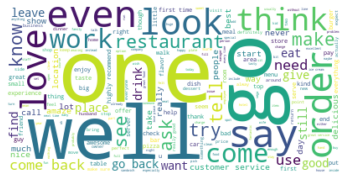

In [48]:
wordcloud_maker(df)

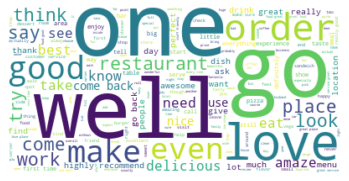

In [49]:
clean_pos = df.loc[df.tag == 'pos']
wordcloud_maker(clean_pos)

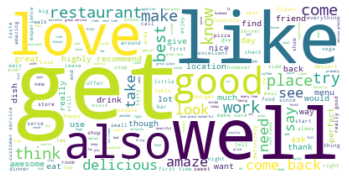

In [50]:
wordcloud_maker(clean_pos, stopwords = ['go', 'one', 'even', 'order'])

## Good Features
Below you can seee my third cleaned wordcloud. This word cloud takes ina list of stopwords created from its previous iterations, words that don't add much function or meaning to the idea of the class. Wors like 'got' or 'said' that don't really weigh in on whether the sentiemnt they are part of is negative or positive. Now that they have been stripped though you can see that the majority of the high frequency words are also high content and highly biased to one class or the other. Ideally these words here shown in the word cloud will also be the words or features the model uses to make its predictions. 

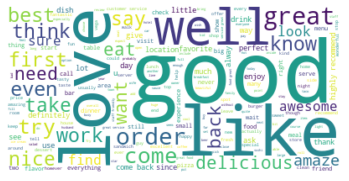

In [51]:
wordcloud_maker(clean_pos, stopwords = ['place', 'one', 'got', 'get', 'said', 'came', 'really', 'go',
                                  'restaurant', 'people', 'would', 'time', 'also', 'went',
                                  'make', 'said'])

## Negative Wordcloud
below are the wordclouds for my negative class. You may ntoice they look very similar to the positive wordclouds. This is because in the english langauge, we often express negation in two parts, the first being the negator followed byt what it is negating. For example, "that was not good"  "I did not like that" "I wasn't impressed" 

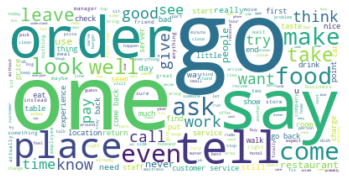

In [52]:
clean_neg = df.loc[df.tag == 'neg']
wordcloud_maker(clean_neg)

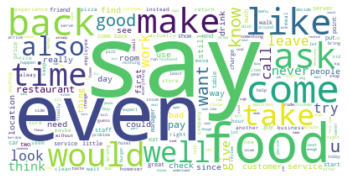

In [53]:
wordcloud_maker(clean_neg, stopwords = ['place', 'one', 'get', 'got', 'go', 'order', 'tell' ])

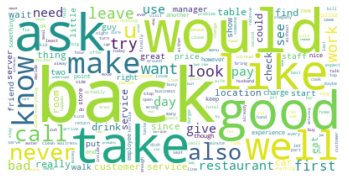

In [54]:
wordcloud_maker(clean_neg, stopwords = ['place', 'one', 'get', 'got', 'next', 
                                  'time', 'food', 'come', 'go', 'coming',
                                  'people', 'still', 'even', 'order', 'think',
                                  'much', 'way', 'may', 'order', 'tell', 'say'])

## Data for Modeling: 
The data I used for modeling comes from a pickled random stratified sample. This data also comes from the Yelp academic data set and by virtueof the way it collected as a random stratifed sample, it maintians the 5:2 ratio for positive and negative data.

In [55]:
df

,stars,tag,clean
1428078,5,pos,tyler amaze wonderful wonderful wonderful indi...
3626079,4,pos,first great beer selection always sit bar get ...
1695262,4,pos,space look different person picture chai latte...
6429535,4,pos,eat plus tax go wrong sushi fresh make order g...
1687838,2,neg,service really slow waitress keep talk someone...
...,...,...,...
2491108,5,pos,best chicken waffle planet earth atmosphere fo...
2599734,5,pos,amaze place come low ish key night plenty room...
2787654,4,pos,great communication prompt attention time prof...
2602863,1,neg,could give place zero would incredibly disorga...


# TF-IDF

To get an idea of how well the data would perform with the data I do an inintial train test split and createa validation set just to see how the mdoels run and if more cleaning is needed. The cleaned data will be passed to a TF-IDF vectorizer,  I also tried a HashVectorizer for more speed and a CountVectorizer but niether performed as well.

In [56]:
data = df['clean']
target = df['tag']
#separate features from target

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    random_state=42,
                                                    test_size=0.25)

In [58]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)
# Secondary train-test split, validation set

In [59]:
vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range=(1,2))
#calculate the TF-IDF score for unigrams and bigrams in text

X_t_vec = vectorizer.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(vectorizer.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [60]:
X_val_vec = vectorizer.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(vectorizer.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [61]:
X_t_vec

,aa,aa brite,aa customer,aa delta,aa employee,aa everything,aa experience,aa grade,aa guess,aa happen,...,zy cy,zz,zz top,zzeek,zzeek rather,zzeeks,zzeeks family,zzs,zzs lf,zzzzzz
1588719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5442485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7678886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4031408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6658355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3366351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3481603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
vectorizer.vocabulary_

{'wife': 976788,
 'visit': 951046,
 'great': 384832,
 'establishment': 285647,
 'religiously': 717150,
 'every': 291269,
 'saturday': 754531,
 'food': 337274,
 'consistently': 185507,
 'amaze': 23857,
 'hot': 421767,
 'fresh': 346271,
 'mouth': 562826,
 'water': 964151,
 'flavor': 331262,
 'take': 867011,
 'place': 653433,
 'next': 580480,
 'level': 488574,
 'though': 890792,
 'service': 777734,
 'kind': 466692,
 'rival': 736675,
 'better': 85083,
 'high': 411960,
 'end': 276095,
 'restaurant': 725882,
 'incredibly': 438751,
 'attentive': 52317,
 'courteous': 197974,
 'thank': 883721,
 'owner': 619144,
 'employee': 274314,
 'notably': 588494,
 'hector': 408009,
 'marcus': 528969,
 'patrick': 632758,
 'torus': 907710,
 'always': 22633,
 'make': 521348,
 'enjoyable': 279144,
 'experience': 300346,
 'wife visit': 977372,
 'visit great': 951506,
 'great establishment': 385561,
 'establishment religiously': 285879,
 'religiously every': 717153,
 'every saturday': 291723,
 'saturday food': 7

# Modeling Data

# FSM

First simple model, a vanilla SGD classifer that takes in clean, tf-idf vectorized data.

In [63]:
%%time

sgd = SGDClassifier()
sgd.fit(X_t_vec, y_t)
sgd_pred = sgd.predict(X_val_vec)
#sgd.score(X_train, y_train), sgd.score(X_test, y_test)
sgd_acc = accuracy_score(y_val, sgd_pred)
sgd_acc

#conf_matrix_plotter(sgd, X_t_vec, y_t)

Wall time: 2min 1s


0.9335859148651661

# GridSearch

Finding the best model out of the eight listed below and tuning their hyperparameters.

In [66]:
lr = LogisticRegression()
mnb = MultinomialNB()
bnb = BernoulliNB()
knn =  KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
sgd = SGDClassifier()

In [67]:
##Logistic Regression Hyperparameters
lr_params = {
   'lr__C':[.1, .75],
   'lr__max_iter':[500],
   'lr__solver':['lbfgs', 'liblinear']
    
            }

##Multinomial Naive Bayes
mnb_params = {    
    'mnb__alpha': [1, .5, .1],
    'mnb__fit_prior': ['True', 'False']
}

##Bernoulli Naive Bayes Hyperparameters
bnb_params = {'bnb__alpha': list(np.linspace(.1, 1, 10))}

##K Nearest Neighbors
knn_params = {
    'knn__n_neighbors': [3, 7, 12], 
    'knn__weights':['uniform', 'distance'], 
    'knn__p':[1, 2, 3, 4]
             }

##Decision Tree
dtc_params = {
    'dtc__criterion':['gini', 'entropy'],  
    'dtc__max_depth': [10, 25, 40, 55],
    'dtc__min_samples_leaf':[1, 2, 3], 
    'dtc__max_features': ['auto', 'sqrt']
              } 

##Random Forest
rfc_params = {
    'rfc__n_estimators':[100, 125],
    'rfc__criterion':['gini', 'entropy'],
    'rfc__max_depth':[20, 40, None],
    'rfc__min_samples_leaf':[1, 2, 3], 
    'rfc__max_features': ['auto','sqrt', 'log2']
                }

##XGBoost
xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [6, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 120]
            }

##SGD Params
sgd_params ={
    'sgd__loss': ['hinge', 'log', 'modified_huber', 'perceptron', 'huber', 'squared_loss'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__alpha': [0.0001, 0.001, 0.01, 0.1],    
}

# Instantiate Pipelines

In [68]:
lr_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('lr', LogisticRegression())])
mnb_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('mnb', MultinomialNB())])
bnb_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('bnb', BernoulliNB())])
knn_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('knn', KNeighborsClassifier())])
dtc_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('dtc', DecisionTreeClassifier())])
rfc_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('rfc', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('xgb', XGBClassifier())])
sgd_pipe = Pipeline(steps =[('tf', TfidfVectorizer()),('sgd', SGDClassifier())])
#creating  pipelines for each models

In [119]:
log_grid = GridSearchCV(estimator = lr_pipe, param_grid = lr_params, scoring = 'accuracy')
log_grid.fit(X_train, y_train)
log_grid.best_params_

{'lr__C': 0.75, 'lr__max_iter': 500, 'lr__solver': 'liblinear'}

In [120]:
mnb_grid = GridSearchCV(estimator = mnb_pipe, param_grid = mnb_params, scoring = 'accuracy')
mnb_grid.fit(X_train, y_train)
mnb_grid.best_params_

{'mnb__alpha': 0.1, 'mnb__fit_prior': 'True'}

In [121]:
bnb_grid = GridSearchCV(estimator = bnb_pipe, param_grid = bnb_params, scoring = 'accuracy')
bnb_grid.fit(X_train, y_train)
bnb_grid.best_params_

{'bnb__alpha': 0.1}

In [29]:
knn_grid = GridSearchCV(estimator = knn_pipe, param_grid = knn_params, scoring = 'accuracy')
knn_grid.fit(X_train, y_train)
knn_grid.best_params_

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid 

{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'uniform'}

In [30]:
dtc_grid = GridSearchCV(estimator = dtc_pipe, param_grid = dtc_params, scoring = 'accuracy')
dtc_grid.fit(X_train, y_train)
dtc_grid.best_params_

{'dtc__criterion': 'gini',
 'dtc__max_depth': 55,
 'dtc__max_features': 'auto',
 'dtc__min_samples_leaf': 3}

In [31]:
rfc_grid = GridSearchCV(estimator = rfc_pipe, param_grid = rfc_params, scoring = 'accuracy')
rfc_grid.fit(X_train, y_train)
rfc_grid.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': None,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 1,
 'rfc__n_estimators': 100}

In [32]:
xgb_grid = GridSearchCV(estimator = xgb_pipe, param_grid = xgb_params, scoring = 'accuracy')
xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

In [122]:
sgd_grid = GridSearchCV(estimator = sgd_pipe, param_grid = sgd_params, scoring = 'accuracy')
sgd_grid.fit(X_train, y_train)
sgd_grid.best_params_

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:

{'sgd__alpha': 0.0001,
 'sgd__loss': 'modified_huber',
 'sgd__penalty': 'elasticnet'}

# Tuned Models

In [123]:
lr_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                 ('lr', LogisticRegression(C = 0.75, max_iter = 500, solver = 'liblinear'))])
#{'lr__C': 0.75, 'lr__max_iter': 500, 'lr__solver': 'liblinear'}


mnb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                  ('mnb', MultinomialNB(alpha = 0.1, fit_prior = True))])
#{'mnb__alpha': 0.1, 'mnb__fit_prior': 'True'}

bnb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                  ('bnb', BernoulliNB(alpha = 0.1))])
#{'bnb__alpha': 0.1}

knn_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),('knn', KNeighborsClassifier())])
#{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'uniform'}

dtc_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                  ('dtc', DecisionTreeClassifier(criterion = 'entropy', max_depth = 55, max_features = 'auto',
                                                                 min_samples_leaf = 3))])
#{'dtc__criterion': 'entropy','dtc__max_depth': 55,'dtc__max_features': 'auto','dtc__min_samples_leaf': 3}


rfc_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                  ('rfc', RandomForestClassifier(criterion = 'gini', max_depth = None, max_features = 'sqrt',
                                                                min_samples_leaf = 1, n_estimators = 125))])        
#{'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__max_features': 'sqrt',
# 'rfc__min_samples_leaf': 1,'rfc__n_estimators': 125}

xgb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),('xgb', XGBClassifier())])

sgd_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer()),
                                  ('sgd', SGDClassifier(alpha = 0.0001, loss = 'modified_huber', penalty = 'elasticnet'))])
#{'sgd__alpha': 0.0001, 'sgd__loss': 'modified_huber', 'sgd__penalty': 'elasticnet'}

Mean Accuracy: 0.9352166329057721


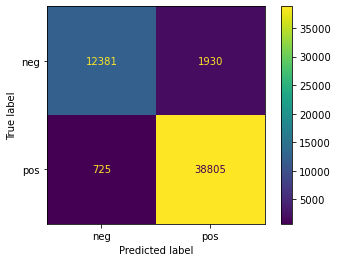

In [124]:
lr_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(lr_pipe_tuned, X_train, y_train); 
print("Mean Accuracy:", cross_val_score(lr_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.8974944557026753


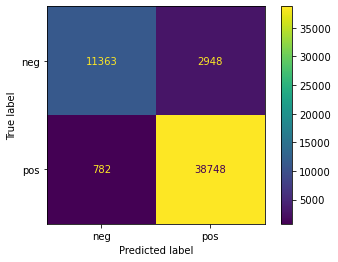

In [125]:
mnb_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(mnb_pipe_tuned, X_train, y_train); 
print("Mean Accuracy:", cross_val_score(mnb_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.8548689937698836


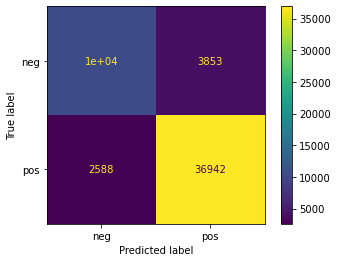

In [126]:
bnb_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(bnb_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(bnb_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.7340131223200379


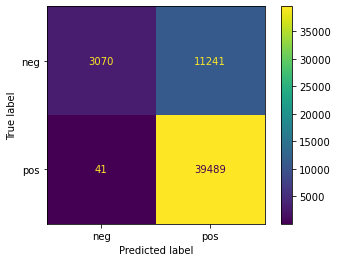

In [127]:
knn_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(knn_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(knn_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.7850336259062907


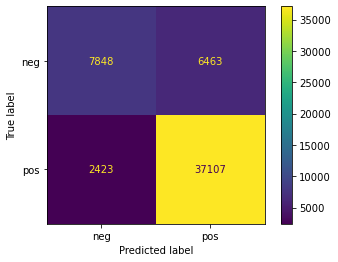

In [128]:
dtc_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(dtc_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(dtc_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.8939098172248034


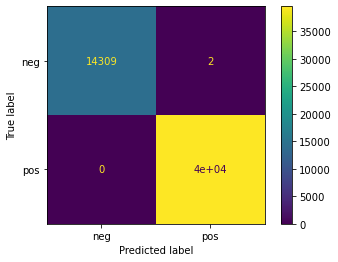

In [129]:
rfc_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(rfc_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(rfc_pipe_tuned, X_train, y_train).mean())

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:30:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Accuracy: 0.9221968735723598


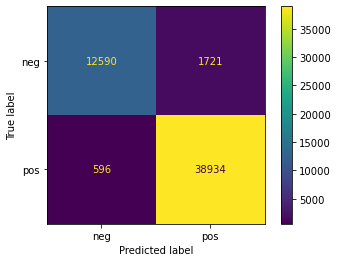

In [130]:
xgb_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.9413086542366047


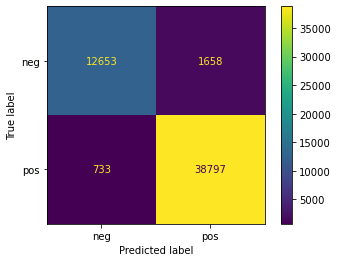

In [131]:
sgd_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(sgd_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned, X_train, y_train).mean())

# Vectorizer Tuning

From the above models the three that did the best were tunes SGD,, tuned logistic regression and untuned XGB. These willbe the three models that will have hteir vectorizers tuned below. 

In [132]:
lr_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(max_features = 5000)),
                                 ('lr', LogisticRegression(C = 0.75, max_iter = 500, solver = 'liblinear'))])
#Mean Accuracy: 0.9293090638930164

xgb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(max_features = 5000)),('xgb', XGBClassifier())])
#Mean Accuracy: 0.9190936106983655

sgd_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(max_features = 5000)),
                                  ('sgd', SGDClassifier(alpha = 0.001, loss = 'modified_huber', penalty = 'L2'))])
#Mean Accuracy: 0.9383358098068351

The first type of tuning I'm going to is try to minimize the number of important features needed to maintain the high accuracy score from above. Each model is tested with a lower and lower amount of featutres and seem to plateau until around 5000 features. 

Mean Accuracy: 0.9274158983251827


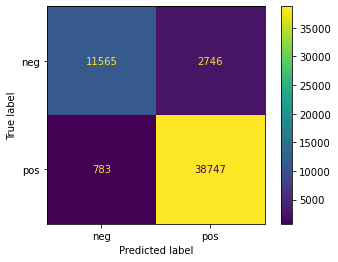

In [133]:
sgd_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(sgd_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned, X_train, y_train).mean())

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Accuracy: 0.9211567374543932


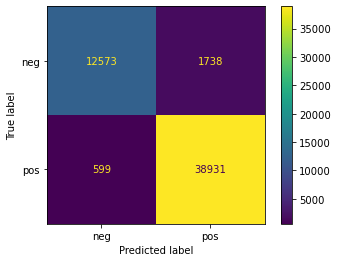

In [134]:
xgb_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())

Mean Accuracy: 0.9365167487244287


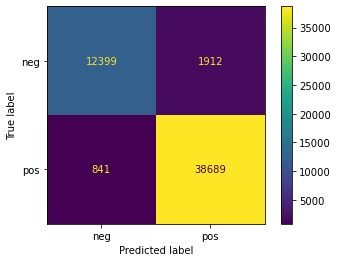

In [135]:
lr_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(lr_pipe_tuned, X_train, y_train); 
print("Mean Accuracy:", cross_val_score(lr_pipe_tuned, X_train, y_train).mean())

## Vectorizer Tuning: By Model

Logistic Regression

In [136]:
lr_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(analyzer = 'word', max_features = 5000)),
                                 ('lr', LogisticRegression(C = 0.75, max_iter = 500, solver = 'liblinear'))])

In [70]:
tf_params = {
    'tf__max_df': (0.25, 0.5, 0.75),
    'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

In [50]:
log_grid = GridSearchCV(estimator = lr_pipe_tuned, param_grid = tf_params, scoring = 'accuracy')
log_grid.fit(X_train, y_train)
log_grid.best_params_

{'tf__max_df': 0.5, 'tf__ngram_range': (1, 3)}

In [144]:
lr_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(analyzer = 'word',max_df = 0.5, ngram_range = (1,3), max_features = 1000)),
                                 ('lr', LogisticRegression(C = 0.75, max_iter = 500, solver = 'liblinear'))])

Mean Accuracy: 0.9286602952147744


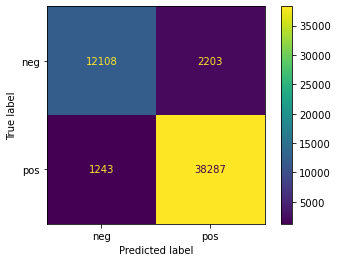

In [145]:
lr_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(lr_pipe_tuned, X_train, y_train); 
print("Mean Accuracy:", cross_val_score(lr_pipe_tuned, X_train, y_train).mean())

XGB

In [138]:
xgb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(analyzer = 'word', max_features = 5000)),('xgb', XGBClassifier())])

In [139]:
xgb_grid = GridSearchCV(estimator = xgb_pipe_tuned, param_grid = tf_params, scoring = 'accuracy')
xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'tf__max_df': 0.5, 'tf__ngram_range': (1, 2)}

In [55]:
xgb_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(analyzer = 'word',max_df = 0.5, 
                                                         ngram_range = (1,2), max_features = 1000)),('xgb', XGBClassifier())])

C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\yelp_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Accuracy: 0.9189821693907876


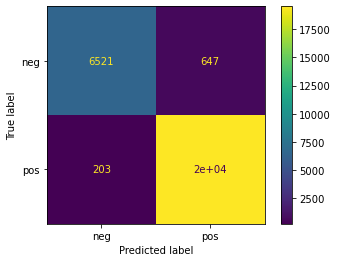

In [73]:
xgb_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())

SGD

In [64]:
sgd_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(max_features = 5000)),
                                  ('sgd', SGDClassifier(alpha = 0.001, loss = 'modified_huber', penalty = 'L2'))])

In [71]:
sgd_grid = GridSearchCV(estimator = sgd_pipe, param_grid = tf_params, scoring = 'accuracy')
sgd_grid.fit(X_train, y_train)
sgd_grid.best_params_

{'tf__max_df': 0.5, 'tf__ngram_range': (1, 1)}

In [72]:
sgd_pipe_tuned = Pipeline(steps =[('tf', TfidfVectorizer(max_df = 0.75, ngram_range = (1,1), max_features = 5000)),
                                  ('sgd', SGDClassifier(alpha = 0.001, loss = 'modified_huber', penalty = 'L2'))])

Mean Accuracy: 0.9279916421951349


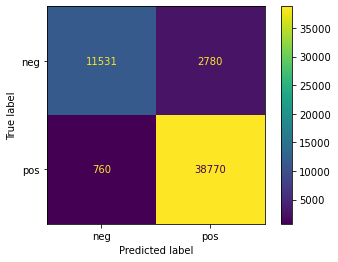

In [73]:
sgd_pipe_tuned.fit(X_train, y_train);
plot_confusion_matrix(sgd_pipe_tuned, X_train, y_train);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned, X_train, y_train).mean())

# Final Model: Test Data

The final model I settled on was an SGD model and it performed at a 92% accuracy. It is a little lower than I anticiapated but still good overall and I think some of the that can be accounted for by the fact that you can have neutral statements in Enlgish. It still does a good job and hug the upper left corner of Roc graph nicely.

Mean Accuracy: 0.9266767149080563


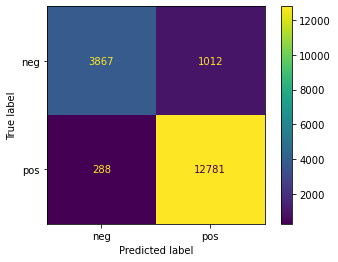

In [74]:
sgd_pipe_tuned.fit(X_train, y_train)

test_preds = sgd_pipe_tuned.predict(X_test)
sgd_acc = accuracy_score(y_test, test_preds)

plot_confusion_matrix(sgd_pipe_tuned, X_test, y_test);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned, X_test, y_test).mean())

In [18]:
#tn,fp, 
#fn, tp

fpr = 527/ (527+1900)
tpr = 6422/ (6422+125)

probs = sgd_pipe_tuned.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label = 'pos')
roc_auc = metrics.auc(fpr, tpr)

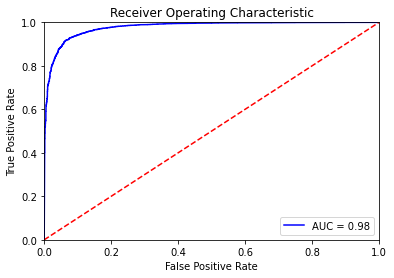

In [19]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Key Features


Below are the features associated with the highest and lowest coefficients. The lower the coefficient the higher influence those words are to the negative classand the higher the coefficient the higher influence those words have to the positive class. The features on either end of the coefficent spectrum make sense. The most interesting find is that the word 'pay' is so highly correlated with being negative as paying is a standard event associated with using a business or service. 

In [78]:
sorted_feats = feature_finder(sgd_pipe_tuned)

In [79]:
sorted_feats.head(20)

,features,values
317,bad,-1.655889
4455,terrible,-1.532229
3773,rude,-1.529867
2156,horrible,-1.508030
458,bland,-1.359977
4436,tell,-1.274530
3208,pay,-1.227050
2767,mediocre,-1.218359
3360,poor,-1.216523
3048,ok,-1.082078


In [80]:
sorted_feats.tail(20)

,features,values
1509,enjoy,0.868674
2049,happy,0.916184
1670,favorite,0.922055
2968,nice,0.953964
2110,highly,0.968828
4467,thank,1.000911
1655,fantastic,1.007818
132,amazing,1.076629
1936,good,1.086539
129,always,1.133715


# Pickle Model

In [25]:
#filename = ('final_sgd_model')
#pickle.dump(sgd_pipe_tuned, open(filename, 'wb'))
#pickle model for later

In [26]:
#loaded_model = pickle.load(filename, 'rb'))
#result = loaded_model.predict(X_test, y_test)
#load pickle model

# Eight Million Review Model

In [168]:
with open ('C:/Users/edwardsrk/final_proj/yelp_reviews_tensorflow/data/pickles/final_7mil', "rb") as model_p: 
    model_7mil = pickle.load(model_p)
#reading in pickled model

In [169]:
test_review = '"Americanized" Asian food; They have a good vegetarian/vegan menu selection, the vegetarian pot stickers were good with a delicious sauce. They even have vegetarian pho that I will try next time.'

In [182]:
def single_review_prep(text):
    """Takes in a single review as a string of text, 
    cleans the review and puts it into a form the model can predict on"""
    clean_test = data_cleaner(test_review)
    dummy_dict= {'star': [clean_test]}
    clean_test_df = pd.DataFrame(dummy_dict)
    return clean_test_df

In [180]:
clean_test_df = single_review_prep(test_review)

In [181]:
model_7mil.predict(clean_test_df.star)

array(['pos'], dtype='<U3')

In [ ]:
# check against 7 mil validatio/test set

In [76]:
def feature_finder(model):
    features = model.steps[0][1].get_feature_names()
    feat_values = model[1].coef_

    c = {'features' : features}
    feats = pd.DataFrame(data = c)
    feats['values'] = feat_values[0]

    sorted_feats = feats.sort_values(by='values')
    return  sorted_feats

In [175]:
feature_finder(model_7mil)

,features,values
304,bad,-1.848564
3700,rude,-1.637779
2154,horrible,-1.563750
4373,terrible,-1.516936
425,bland,-1.284881
...,...,...
127,amaze,1.590445
386,best,1.679702
2561,love,1.720188
1053,delicious,1.734034


In [184]:
clean_word_list = clean_test_df.star.tolist()

In [3]:
clean_word_list

NameError: name 'clean_word_list' is not defined

In [1]:
word_list = []
for i in clean_word_list:
    word_list.append(i)

NameError: name 'clean_word_list' is not defined

In [2]:
word_list

[]

# Grubhub Review Data

To test my model out on actual 3 star reviews I had to compile my own corpus of tagged data. In another notebook call INSERT NAME HERE, I used Selenium along with a custom scraper to scrape data from the popular food ordering app called Grubhub. The data I scraped includes a star rating, a text review and sentiment tag provided by Grubhub as positive, negative or neutral. This dataset allows me to test my model against tagged 3 star reviews as a method of evalutation. The reviews are all of local Seattle restaurants and the set contains about 2500 reviews rated from 1 to 5 stars.

In [76]:
gb_df = pd.read_csv("C:/Users/edwardsrk/final_proj/yelp_reviews_tensorflow/data/grubhub_data.csv")

In [77]:
gb_df =gb_df.drop('Unnamed: 0', axis = 1)
gb_df.head()

,stars,tags,text
0,3,Positive,Food was good but it came an hour early.
1,1,Negative,Meh. And driver was blasting music in his car
2,4,Positive,Best Thai food nearby!
3,4,Positive,Great food! Just not a timely delivery
4,4,Positive,The food was delicious.


In [78]:
one_star = gb_df[gb_df['stars'] == 1]
two_star = gb_df[gb_df['stars'] == 2]
three_star = gb_df[gb_df['stars'] == 3]
four_star = gb_df[gb_df['stars'] == 4]
five_star = gb_df[gb_df['stars'] == 5]

In [79]:
len(five_star), len(four_star), len(three_star), len(two_star), len(one_star)


(945, 331, 356, 304, 566)

# Grubhub EDA

The ratio of reviews for the over all data set is 3 positive to 2 negative.

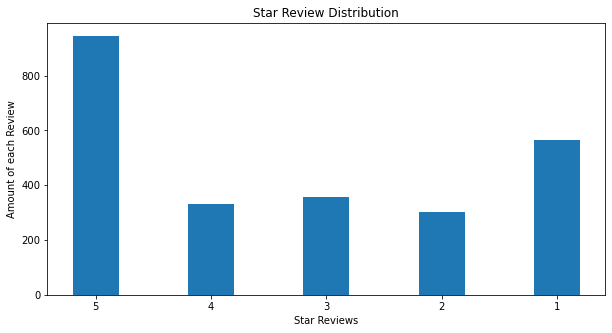

In [40]:
lens = {'5' :len(five_star), '4':len(four_star), '3' :len(three_star), '2' :len(two_star), '1' : len(one_star)}

x = list(lens.keys())
y = list(lens.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(x,y, width = 0.4)

plt.xlabel("Star Reviews")
plt.ylabel("Amount of each Review")
plt.title("Star Review Distribution")
plt.show()

In [41]:
three_star.tags.value_counts()

Negative    202
Positive    107
Neutral      47
Name: tags, dtype: int64

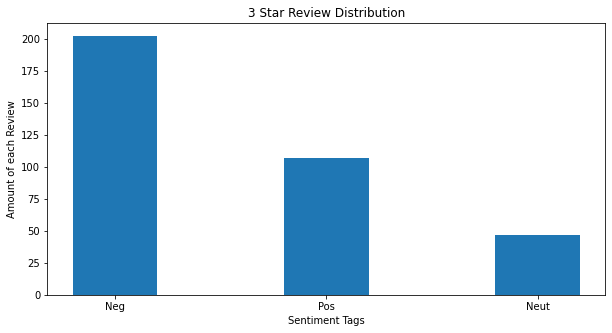

In [42]:
dist_list = list(three_star.tags.value_counts())
data = {'Neg' : dist_list[0], 'Pos': dist_list[1], 'Neut': dist_list[2]}
x = list(data.keys())
y = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(x,y, width = 0.4)

plt.xlabel("Sentiment Tags")
plt.ylabel("Amount of each Review")
plt.title("3 Star Review Distribution")
plt.show()

In [80]:
df_gb_split = [four_star, five_star, one_star, two_star]
df_gb = pd.concat(df_gb_split)
#concat all for extra test set

In [81]:
df_gb.stars.value_counts()

5    945
1    566
4    331
2    304
Name: stars, dtype: int64

In [82]:
three_star_binary = three_star[three_star.tags != 'Neutral']

In [83]:
three_star_binary.tags.value_counts()

Negative    202
Positive    107
Name: tags, dtype: int64

In [84]:
df_gb = df_gb[df_gb.tags != 'Neutral']
df_gb.tags.value_counts()

Positive    1115
Negative     859
Name: tags, dtype: int64

In [85]:
grub = gb_cleaner(df_gb)
grub.head()

,tag,clean
2,pos,best thai food nearby
3,pos,great food timely delivery
4,pos,food delicious
7,pos,excellent steam vegetable pharmacy see lew
8,pos,food great packaging much sauce soup spill poo...


In [86]:
df_gb_pos = grub[grub.tag != 'neg']
df_gb_neg = grub[grub.tag != 'pos']

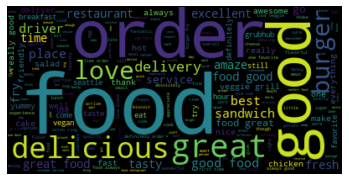

In [50]:
wordcloud_maker(df_gb_pos)

The most prominent negative word shere differ greatly thanthose rpesented within the Yelp review dataset. These are much more focused on the performance of Grubhub and their drivers than on the business itself.

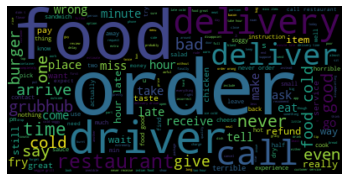

In [51]:
wordcloud_maker(df_gb_neg)

C:\Users\edwardsrk\final_proj\yelp_reviews_tensorflow\src\yelp.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tag'] = df.tags.apply(retagger)
C:\Users\edwardsrk\final_proj\yelp_reviews_tensorflow\src\yelp.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean'] = clean_corpus


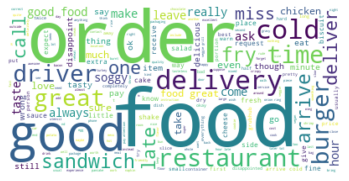

In [89]:
grub_3 = gb_cleaner(three_star_binary)
wordcloud_maker(gb_cleaner(three_star_binary))

# Grubhub Modeling

In [156]:
grub_3.head()
X = grub_3.clean
y = grub_3.tag
#splitting the 3 star review data into chunks ot predict on

,tag,clean
0,pos,food good come hour early
10,neg,usually favorites order spice level one dish b...
18,neg,disappointment long time neighbor make everyth...
19,neg,really good food slow
45,pos,remind essentially fast food mind decent food ...


In [124]:
x_list = X.tolist()

In [126]:
x_list[5]

'good food get order wrong unacceptable'

In [167]:
#model_sgd.fit(X, y)
#score = model_sgd.score(X,y)
#print("Test score: {0:.2f} %".format(100 * score))  
test_preds = model_sgd.predict(X)
#test_preds
sgd_acc = accuracy_score(y, test_preds)

plot_confusion_matrix(model_sgd, X, y);
print("Mean Accuracy:", cross_val_score(model_sgd, X, y).mean())


KeyboardInterrupt: 

In [ ]:
Do to the poor performance of the model above I am going to train a my existing model on the available Grubhub dataset.

In [62]:
data = grub['clean']
target = grub['tag']
#separate features from target
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    random_state=42,
                                                    test_size=0.25)

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)
# Secondary train-test split, validation set

This mdoel does better on the data without the three star data included in it but does just about the same when tested on the three star data as the original model.

Mean Accuracy: 0.8481962481962482


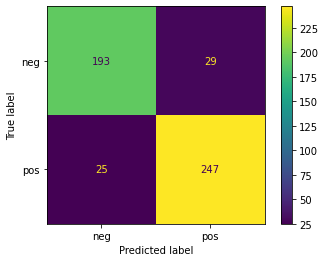

In [64]:
sgd_pipe_tuned_gb = Pipeline(steps =[('tf', TfidfVectorizer(max_df = 0.75, ngram_range = (1,2), max_features = 5000)),
                                  ('sgd', SGDClassifier(alpha = 0.001, loss = 'modified_huber', penalty = 'L2'))])

sgd_pipe_tuned_gb.fit(X_train, y_train)

test_preds = sgd_pipe_tuned_gb.predict(X_test)
sgd_acc = accuracy_score(y_test, test_preds)

plot_confusion_matrix(sgd_pipe_tuned_gb, X_test, y_test);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned_gb, X_test, y_test).mean())

Once again, taking a look at the features highly correlated with the negative class you can see they are very different than the negative features from the original model.

In [77]:
features = sgd_pipe_tuned_gb.steps[0][1].get_feature_names()
feat_values = sgd_pipe_tuned_gb[1].coef_

c = {'features' : features}
feats = pd.DataFrame(data = c)
feats['values'] = feat_values[0]

sorted_feats = feats.sort_values(by='values')
sorted_feats

#feature_finder(model)

,features,values
139,bad,-1.965281
1815,miss,-1.861295
393,cold,-1.693209
4347,terrible,-1.286961
108,ask,-1.271601
...,...,...
1068,good,1.787819
177,best,1.913286
1453,love,2.102992
530,delicious,2.316490


Mean Accuracy: 0.7573241671073505


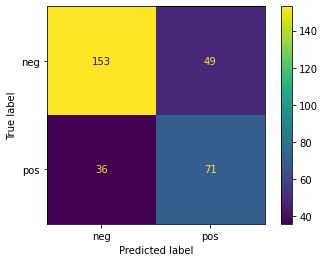

In [80]:
sgd_pipe_tuned_gb.fit(X_train, y_train)

#score = sgd_pipe_tuned_gb.score(X,y)
#print("Test score: {0:.2f} %".format(100 * score))  

test_preds = sgd_pipe_tuned_gb.predict(X)
sgd_acc = accuracy_score(y, test_preds)

plot_confusion_matrix(sgd_pipe_tuned_gb, X, y);
print("Mean Accuracy:", cross_val_score(sgd_pipe_tuned_gb, X, y).mean())

# Next Steps

Next steps: 
-Making a NER model to create an entitty distinction between Grubhub and the actual business attached to the orders
-Gathering more data to input into another model for better predictions
-Figure out how to deal with the opposite distribution
-Deploy an app in Flask that you can type a review into